In [27]:
%pip install pydot
%brew install graphviz


Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%brew` not found.


In [14]:
from glob import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf

# CNN Building Tools below-these lines are causing problems in the code for some reason
import keras
from keras import layers, models
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Dropout, BatchNormalization
from keras import backend as K

# from images.ipynb import load_images
from keras.backend import clear_session
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = []
df = pd.read_csv("HAM10000_metadata_augmented.csv")
# df = df.sort_values(by="image_id")
lesion_type_dict = {
    "nv": "Melanocytic nevi",
    "mel": "Melanoma",
    "bkl": "Benign keratosis-like lesions",
    "akiec": "Actinic keratoses",
    "vasc": "Vascular lesions",
    "df": "Dermatofibroma",
    "bcc": "Basal Cell Carcinoma",
}
df

,image_id,dx,dx_type,lesion_id,sex,age,localization
0,ISIC_0034320,nv,follow_up,HAM_0000550,male,45.0,trunk
1,ISIC_0034320,nv,follow_up,HAM_0003577,male,50.0,lower extremity
2,ISIC_0034320,nv,follow_up,HAM_0001477,female,55.0,trunk
3,ISIC_0034320,nv,follow_up,HAM_0000484,male,40.0,trunk
4,ISIC_0034320,mel,histo,HAM_0003350,male,60.0,chest
...,...,...,...,...,...,...,...
40944,ISIC_0034320,bkl,histo,HAM_0000344,male,55.0,trunk
40945,ISIC_0034320,bkl,histo,HAM_0000344,male,55.0,trunk
40946,ISIC_0034320,bkl,histo,HAM_0000344,male,55.0,trunk
40947,ISIC_0034320,nv,histo,HAM_0000747,male,30.0,trunk


In [4]:
len(df)
val_size = round(len(df) * 0.15)
test_size = round(len(df) * 0.1)


In [5]:
images = np.load("augment_images.npy")
image_x_train = images[test_size + val_size :].astype("float32")
image_x_val = images[test_size : test_size + val_size].astype("float32")
image_x_test = images[:test_size].astype("float32")

In [6]:
img = Image.open("HAM10000_images/ISIC_0024306.jpg")
img = np.array(img.resize((100,100)))
print(img[0][0])
print(images[0][0][0])

[228 131 133]
[228. 131. 133.]


In [7]:
# Make Label
target = df[["dx"]]
target = pd.get_dummies(target, columns=["dx"])
y_train = target[test_size+val_size:].astype("float32")
y_val = target[test_size : test_size + val_size].astype("float32")
y_test = target[:test_size].astype("float32")

In [8]:
features = df[["age", "sex", "localization"]]
features = pd.get_dummies(features)
features
features_x_train = features[test_size + val_size :]
features_x_val = features[test_size : test_size + val_size]
features_x_test = features[:test_size]

In [9]:
# Start of CNN Building
input_shape = (100, 100, 3)
num_classes = 7

In [16]:
# Initialising the CNN
model_cnn = Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding="Same"),
        MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        Conv2D(64, (3, 3), activation="relu", padding="Same"),
        Conv2D(64, (3, 3), activation="relu", padding="Same"),
        MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        Conv2D(64, (3, 3), activation="relu", padding="Same"),
        Conv2D(32, (3, 3), activation="relu", padding="Same"),
        MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        Flatten(),
        layers.Dropout(0.25),
        Dense(256, activation="relu"),
    ]
)

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 50, 50, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 64)        36928     
                                                      

In [17]:
# text = df[["age", "localization", "sex"]]
# text = pd.get_dummies(text, columns=["localization", "sex"])
# text_x_train = np.array(text[:6000])
# text_x_test = np.array(text[6000:7600])
# text_x_val = np.array(text[7600:])
# text_y_train = np.array(target[:6000])
# text_y_test = np.array(target[6000:7600])
# text_y_val = np.array(target[7600:])
# # print(text_x_train[:10])

In [18]:
model_txt = Sequential([
    layers.InputLayer(input_shape=(19,)),
    layers.Reshape((19, 1)),
    Conv1D(128, 3, activation="gelu"),
    MaxPool1D(2),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(256)
])
model_txt.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 19, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 128)            0         
 D)                                                              
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                      

In [19]:

# text_side = model_txt(text_x_train)

In [20]:
# x_train = np.array([])
# # for i in range (0, len(image_x_train)):
# #     x_train[i] = text_train[i] + image_x_train[i]
# #     x_train = np.array([np.array([text_x_train[i], image_x_train[i]])])

# # x_train[0] = np.array([text_x_train[0], image_x_train[0]])

# x_train = [[features_x_train[i], image_x_train[i]] for i in range(0, len(image_x_train))]
# x_val = [[features_x_train[i], image_x_val[i]] for i in range(0, len(image_x_val))]
# x_test = [[features_x_test[i], image_x_test[i]] for i in range(0, len(image_x_test))]

In [21]:
# tmp = x_train[0][1]
# print(len(x_train))
# print(type(x_train[0][0]))
# print(len(tmp))
# print(tmp.shape)
# print(type(tmp))
# # print(tmp)

In [22]:
img_input = layers.Input(shape=input_shape, dtype=tf.int32, name="img")
txt_input = layers.Input(shape=(19,), dtype=tf.int32, name="txt")
image_side = model_cnn(img_input)
text_side = model_txt(txt_input)

merged = layers.Concatenate()([image_side, text_side])
merged = layers.Dense(256, activation="relu")(merged)
output = layers.Dense(7, activation="softmax", name="class")(merged)
model = models.Model([img_input, txt_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 txt (InputLayer)            [(None, 19)]                 0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 256)                  1300864   ['img[0][0]']                 
                                                                                                  
 sequential_5 (Sequential)   (None, 256)                  328704    ['txt[0][0]']                 
                                                                                              

In [23]:
# Define the optimizer
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001
)

In [50]:
import gc
epochs = 50
batch_size = 170


class garbageCollectCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=2,
    mode="max",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

history = model.fit(
    [image_x_train, features_x_train],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=6000 // batch_size,
    callbacks=[garbageCollectCallback(), earlyStopping],
    validation_data=([image_x_val, features_x_val], y_val),
)

Epoch 1/50
35/35 [==============================] - 191s 5s/step - loss: 0.9054 - accuracy: 0.6563 - val_loss: 1.0031 - val_accuracy: 0.6482
Epoch 2/50
35/35 [==============================] - 170s 5s/step - loss: 0.9047 - accuracy: 0.6615 - val_loss: 1.0141 - val_accuracy: 0.6430
Epoch 3/50
35/35 [==============================] - 164s 5s/step - loss: 0.9005 - accuracy: 0.6610 - val_loss: 1.0050 - val_accuracy: 0.6421
Epoch 4/50
35/35 [==============================] - 4594s 135s/step - loss: 0.8996 - accuracy: 0.6528 - val_loss: 0.9928 - val_accuracy: 0.6517
Epoch 5/50
35/35 [==============================] - 2284s 67s/step - loss: 0.9061 - accuracy: 0.6563 - val_loss: 0.9470 - val_accuracy: 0.6579
Epoch 6/50
35/35 [==============================] - 201s 6s/step - loss: 0.8709 - accuracy: 0.6650 - val_loss: 1.0058 - val_accuracy: 0.6319
Epoch 7/50
35/35 [==============================] - 175s 5s/step - loss: 0.8662 - accuracy: 0.6711 - val_loss: 0.9939 - val_accuracy: 0.6457
Epoch 8/

In [ ]:
model.evaluate([image_x_test, features_x_test], y_test, verbose=2)

128/128 - 24s - loss: 1.0847 - accuracy: 0.6154 - 24s/epoch - 184ms/step


[1.0846898555755615, 0.6153846383094788]

In [48]:
predictions = model.predict([image_x_test, features_x_test])
class_prediction = [np.argmax(prediction) for prediction in predictions]
class_y_test = [np.argmax(y) for y in y_test.to_numpy()]

128/128 [==============================] - 29s 226ms/step


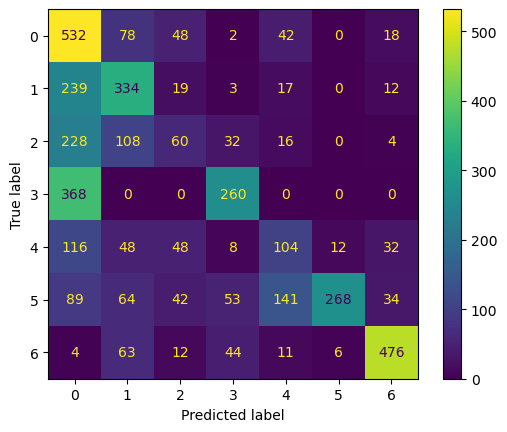

In [45]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(class_y_test, class_prediction)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix
)
cm_display.plot()
plt.show()